# Data Cleaning

In [264]:
'''
Import required packages and libraries for data exploration
'''
import pandas as pd
import numpy as np
import re

In [289]:
'''
Set up file path and data handling objects
'''
PATH = "../data/reviews.csv"
data = pd.read_csv(PATH)

In [290]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


## Case Sensitivity
Convert the input features in the raw dataset into a case insensitive format (all lowercase/uppercase) to reduce the amount of distinct words in the data.

In [291]:
# Remove null values from tokenizer strings
data["Summary"] = data["Summary"].fillna("")
data["Text"] = data["Text"].fillna("")

In [292]:
# Convert all words to lowercase to reduce the number of unique features
data["Summary"] = data["Summary"].str.lower()
data["Text"] = data["Text"].str.lower()

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,good quality dog food,i have bought several of the vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""delight"" says it all",this is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,cough medicine,if you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy,great taffy at a great price. there was a wid...


## Punctuation Handling
Some words that contain punctuation can be recorded as separate features without punctuation handling (e.g., "Steve's pizza is great!" and "Steve makes great pizza!").

| is | great | great! | makes | pizza | pizza! | Steve | Steve's |
|----|-------|--------|-------|-------|--------|-------|---------|
|1   | 1     | 1      | 1     | 1     | 1      | 1     | 1       |

We want to remove uncessesary punctuation so that we don't have duplicates of effectively the same word.
| is | great | makes | pizza | Steve |
|----|-------|-------|-------|-------|
| 1  | 2     | 1     | 2     | 2     |

Doing this prevents our model from interpreting duplicate words as two separate features and reduces the number of dimensions our model has to process (increasing efficiency).

In [293]:
pattern = r"(?u)\b\w\w+\b"
tokenizer = lambda string : " ".join(re.findall(pattern=pattern, string=string))

data["Summary"] = data["Summary"].apply(tokenizer)
data["Text"] = data["Text"].apply(tokenizer)

## Remove Filler Words
Some words like "I", "the", "a", etc. don't impact the sentiment of the text content. Remove these words from all review content so there is less redundant features for the final model.

In [231]:
import nltk
from nltk.corpus import stopwords    

print("Downloading NLTK stopwords...")
nltk.download('stopwords', quiet=True)
    
stop_words = set(stopwords.words('english'))

# Print sample of stopwords
print("\nSample of English stopwords:")
print(sorted(list(stop_words))[:10])  # Print first 10 stopwords

def remove_stopwords_from_text(text):
    if pd.isna(text):
        return text
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Process both columns
print("Removing stop words from Summary...")
data['Summary'] = data['Summary'].apply(remove_stopwords_from_text)

print("Removing stop words from Text...")
data['Text'] = data['Text'].apply(remove_stopwords_from_text)

# Print samples for verification
print("\nSample of processed Summary:")
print(data['Summary'].head())
print("\nSample of processed Text:")
print(data['Text'].head())
    


Sample of English stopwords:
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']
Removing stop words from Summary...
Removing stop words from Text...

Sample of processed Summary:
0    good quality dog food
1               advertised
2             delight says
3           cough medicine
4              great taffy
Name: Summary, dtype: object

Sample of processed Text:
0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanuts p...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object


## Remove Irrelevant Data Points
The first stage of data cleaning is to identify and remove data points that aren't related to our task. In "Amazon Fine Food Reviews", we have many different product reviews including: pet food, medicine, microwavable food, fine foods, etc.
- Is this category of food or type of review relevant to our task?
- Would removing this type of review from the data improve the accuracy of our model?
- If we remove this type of review, how will it effect our training process (would there be too little data remaining?)

In [294]:
non_aspects = {
    "pet_species":[
        "dog","cat","puppy","kitten","fish","hamster","rabbit","guinea pig","bird","parrot","turtle",
        "lizard", "snake", "ferret", "gerbil", "chinchilla", "mouse", "rat", "iguana", "gecko",
        "dogs","cats","puppys","kittens","fishs","hamsters","rabbits","guinea pigs","birds","parrots","turtles",
        "lizards", "snakes", "ferrets", "gerbils", "chinchillas", "mouses", "rats", "iguanas", "geckos"
    ],
    "pet_food_brands":[
        "purina", "pedigre", "iams", "blue buffalo", "hill science diet", "royal canin", "fancy feast", "friskies",
        "cesar", "meow mix", "nutro", "wellness", "orijen", "acana", "greenies", "temptations", "whiskas"
    ],
    "digestive": [
        "nausea", "vomiting", "diarrhea", "constipation", "bloating",
        "stomach ache", "indigestion", "heartburn", "cramps", "gas"
    ],
    "neurological": [
        "headache", "migraine", "dizziness", "fatigue", "insomnia",
        "brain fog", "numbness", "tingling", "vertigo"
    ],
    "respiratory": [
        "cough", "shortness of breath", "wheezing", "congestion",
        "runny nose", "sore throat", "sneezing"
    ],
    "skin": [
        "rash", "itching", "hives", "acne", "eczema", "redness",
        "dry skin", "swelling"
    ],
    "pain": [
        "pain", "ache", "soreness", "stiffness", "joint pain",
        "back pain", "chest pain", "muscle pain"
    ],
    "psychological": [
        "anxiety", "depression", "irritability", "mood swings",
        "panic attacks", "restlessness"
    ],
    "general": [
        "fever", "chills", "sweating", "weakness", "loss of appetite",
        "weight loss", "weight gain"
    ],
    "allergic": [
        "allergy", "anaphylaxis", "sensitivity", "intolerance",
        "swelling of the lips", "swelling of the throat"
    ]
}

In [295]:
def search_prod(value, dataframe, series):
    products = set()

    for i, string in enumerate(series):
        if re.search(pattern=f"{value} ", string=string):
            products.add(dataframe.iloc[i]["ProductId"])
    return products

In [296]:
for key in non_aspects.keys():
    for value in non_aspects[key]:
        sum_id = search_prod(value=value, dataframe=data, series=data["Summary"])
        txt_id = search_prod(value=value, dataframe=data, series=data["Text"])
        prod_id = sum_id.union(txt_id)
        
        data = data[~data["ProductId"].isin(prod_id)]


In [297]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,201853.000000,201853.000000,201853.000000,201853.000000,2.018530e+05
mean,285589.447806,1.472839,1.883643,4.211253,1.296484e+09
std,164068.765008,4.093552,4.709997,1.311492,4.942911e+07
min,2.000000,0.000000,0.000000,1.000000,9.617184e+08
25%,142410.000000,0.000000,0.000000,4.000000,1.269994e+09
50%,283227.000000,0.000000,1.000000,5.000000,1.312934e+09
75%,428757.000000,2.000000,2.000000,5.000000,1.334016e+09
max,568454.000000,580.000000,593.000000,5.000000,1.351210e+09


In [298]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,delight says it all,this is confection that has been around few ce...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy,great taffy at great price there was wide asso...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,nice taffy,got wild hair for taffy and ordered this five ...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,great just as good as the expensive brands,this saltwater taffy had great flavors and was...


## Remove Uncecessary Columns
- What columns are necessary for our model? 
- Is there anything that needs to be removed?

In [299]:
# Only include features that can be plotted in correlation matrix
# String features cannot be intepreted in correlation matrix
numeric_data = data.drop(columns=["ProductId", "UserId", "ProfileName", "Summary", "Text"])

In [238]:
data["Text"] = data["Summary"].fillna("") + " " + data["Text"].fillna("")

In [300]:
# As seen in the data exploration stage, most numerical features excluding 
# the newly created "Helpfulness" were not indicative of Score
data = data.drop(columns=[
    "Id",
    "UserId", 
    "ProfileName", 
    "HelpfulnessNumerator", 
    "HelpfulnessDenominator",
    "Time",
    "Summary"
])

In [301]:
data.head()

,ProductId,Score,Text
1,B00813GRG4,1,product arrived labeled as jumbo salted peanut...
2,B000LQOCH0,4,this is confection that has been around few ce...
4,B006K2ZZ7K,5,great taffy at great price there was wide asso...
5,B006K2ZZ7K,4,got wild hair for taffy and ordered this five ...
6,B006K2ZZ7K,5,this saltwater taffy had great flavors and was...


## Convert Columns to Numerical
For the more complex columns we will be doing word embedding. However, features such as 'ProductId' can be converted into numerical form so the model has an easier time interpreting it.

In [302]:
data["ProductId"] = pd.factorize(data["ProductId"])[0]

In [303]:
data.head()

,ProductId,Score,Text
1,0,1,product arrived labeled as jumbo salted peanut...
2,1,4,this is confection that has been around few ce...
4,2,5,great taffy at great price there was wide asso...
5,2,4,got wild hair for taffy and ordered this five ...
6,2,5,this saltwater taffy had great flavors and was...


## Entity Split
In this section we need to split the dataset into single entity and multiple entity data points. This step is necessary because the framework for our model requires that single entity data points are handled by **model A** and multiple entity data points are handled by **model B**.

In [ ]:
import nltk
import spacy
from nltk.corpus import wordnet as wn

nltk.download('wordnet')

In [371]:
nlp = spacy.load("en_core_web_sm")

def is_valid_noun(word):
    doc = nlp(word)
    is_noun = doc[0].pos_ in ["NOUN", "PROPN"]
    in_wordnet = any(ss.pos() == 'n' for ss in wn.synsets(word))
    return is_noun and in_wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cyrus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [407]:
tokens = nltk.word_tokenize(data.iloc[200]["Text"])
tagged = nltk.pos_tag(tokens=tokens)
entities = nltk.chunk.ne_chunk(tagged)

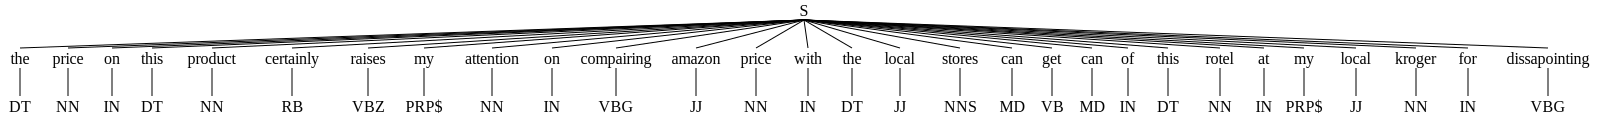

In [408]:
entities

In [409]:
aspects     = []
sentiments  = []

aspect_tags     = {"NN"}
sentiment_tags  = {"JJ", "JJR", "JJS", "RBR", "RBS"}

for i, tag in enumerate(tagged):
    if tag[1] in sentiment_tags:
        sentiments.append(((tag[0]), i))
    if tag[1] == "VBN":
        for k in range(1, len(tag[0])):
            if is_valid_noun(tag[0][:-k]):
                aspects.append((tag[0][:-k], i))
                break
    elif tag[1] in aspect_tags:
        aspects.append((tag[0], i))

In [410]:
print(aspects)
print(sentiments)

[('price', 1), ('product', 4), ('attention', 8), ('price', 12), ('rotel', 22), ('kroger', 26)]
[('amazon', 11), ('local', 15), ('local', 25)]


In [306]:
data.iloc[0]["Text"]

'product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo'

## Word Embedding

In [ ]:
import json
from scipy.sparse import lil_matrix
from scipy.sparse import vstack
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
RESULTS_PATH = "Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json"

# Open and load the JSON file
with open(RESULTS_PATH, 'r') as file:
    results = json.load(file)

In [ ]:
sentiment_to_score = {
    "Negative" : 1,
    "Neutral"  : 2,
    "Positive" : 3
}

In [ ]:
# Build vocabulary of all unique aspect terms
all_aspects = set()

for result in results:
    for aspect in result.get("aspect", []):
        all_aspects.add(aspect)

In [ ]:
# Assign each aspect a column index
aspect_names = sorted(all_aspects)
aspect_vocab = {aspect: idx for idx, aspect in enumerate(aspect_names)}
n_samples    = len(results)
n_features   = len(aspect_vocab)

In [ ]:
# Create sparse matrix using LIL (good for row-wise construction)
sentiment_matrix = lil_matrix((n_samples, n_features), dtype=np.float32)

# Keep track of rows with one or fewer aspect counts
nonzero_counts = []

In [ ]:
# Fill the matrix
for i, result in enumerate(results):
    aspects     = result.get("aspect", [])
    sentiments  = result.get("sentiment", [])
    count       = 0
    for aspect, sentiment in zip(aspects, sentiments):
        col_idx = aspect_vocab.get(aspect)
        if col_idx is not None:
            sentiment_score = sentiment_to_score.get(sentiment, 0)
            sentiment_matrix[i, col_idx] = sentiment_score
            count += 1

    nonzero_counts.append(count)

# Convert to CSR for efficient arithmetic / storage
sentiment_matrix = sentiment_matrix.tocsr()

In [ ]:
# Filter indicies
low_aspect_indicies     = [i for i, count in enumerate(nonzero_counts) if count <= 1]
high_aspect_indicies    = [i for i, count in enumerate(nonzero_counts) if count > 1]

# Create two separate matrices
low_aspect_matrix   = sentiment_matrix[low_aspect_indicies]
high_aspect_matrix  = sentiment_matrix[high_aspect_indicies]

In [ ]:
'''
Let's say:
    - "sentiment_matrix" is your sparse matrix (CSR format)
    - "data" is your original DataFrame with columns like "Score", "ProductID", "Helpfulness"
'''

# Dense columns for inclusion into sparse matrix
dense_features = ["ProductId", "Helpfulness", "Score"]

# Get dense data for each split
low_dense   = data.iloc[low_aspect_indicies][dense_features].values
high_dense  = data.iloc[high_aspect_indicies][dense_features].values

# Convert dense to sparse and stack
low_combined    = hstack([csr_matrix(low_dense), low_aspect_matrix])
high_combined   = hstack([csr_matrix(high_dense), high_aspect_matrix])

In [ ]:
column_names = dense_features + aspect_names

## Save to External Dataset

In [ ]:
import joblib

In [ ]:
# Save both matrix and column names
joblib.dump({
    "matrix": low_combined,
    "columns": column_names
}, "single_aspect.pkl")

joblib.dump({
    "matrix": high_combined,
    "columns": column_names
}, "multi_aspect.pkl")

['multi_aspect.pkl']